# Antes de empezar

conda activate python3.6_cv2

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2
import skimage

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import platform
print(torch.__version__)
print(platform.python_version())
torch.cuda.get_device_name(0)

1.9.0
3.6.10


'Quadro RTX 5000'

## Cargando datos

In [3]:
def loadWords(file_name):
    top_30000_words = pd.read_csv(file_name, delimiter = '\t', header = None, keep_default_na=False)
    src_words = []
    sample_length = len(top_30000_words)

    for i in range(sample_length):
        src_words.append(top_30000_words.loc[i][0])

    total_length = len(src_words)
    return src_words,total_length

In [4]:
src_words,total_length = loadWords('30k.txt') 
print("Palabras: ", total_length)
print("Las primeras: ", src_words[0:10])

Palabras:  30000
Las primeras:  ['the', 'of', 'and', 'to', 'a', 'in', 'for', 'is', 'on', 'that']


## Eliminar palabras de tamaño grande

In [5]:
def deleteBigWords(max_len,words):
    output = words.copy()

    huge_words = 0

    for i in range(total_length):
        if len(output[i]) > max_len:
            output[i] = output[i-1]
            huge_words += 1

    print("Palabras largas cambiadas: ", huge_words)
    return output

In [6]:
words = deleteBigWords(15,src_words)

Palabras largas cambiadas:  35


## Definiendo conjuntos de train, test y validación

In [7]:
train_set = words[0:28000]
val_set = words[28000:29000] 
test_set = words[29000:30000]
test_set_2 = words[20000:21000] # (seen during training, the network shoud have memorised it)

MAX_LENGTH = max(len(word) for word in words) # length of the longest word within our sample

print(MAX_LENGTH)

15


In [8]:
letters = ['START', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
          'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'END', 'PAD']

mapeo = {}

cont = 0
for key in letters:
    vector = torch.zeros(1, 1, len(letters))
    vector[0,0,cont] = 1.0
    mapeo[key] = vector
    cont += 1

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [9]:
def patch_gen(word, n_patches, patch_height, patch_width, stepsize, color_channels):
    
    image = 255 * np.ones(shape = (height, width), dtype = np.uint8)
    image = cv2.putText(image, text = word, org = (5, 30),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.62, color = (0, 0, 0),
        thickness = 1, lineType = cv2.LINE_AA)
    #image = skimage.util.random_noise(image, mode='s&p')
    image = transforms.ToPILImage()(image) # np.ndarray to PIL.Image.Image
    patches_tensor = torch.empty(n_patches, color_channels, patch_height, patch_width)
    patches_tensor = patches_tensor.cuda(0)
    
    for p in range(n_patches):
        
        patch = transforms.functional.crop(image, 0, 0 + p * stepsize, patch_height, patch_width) # cropping of the image into patches
        patch = transforms.ToTensor()(patch) # torch.Tensor of the patch (normalized)
        #patch = torch.from_numpy(patch) # conversion to pytorch tensor again
        patch = 1. - patch # it will work better if we have white text over black background
        patch = patch.view(1, 1, patch_height, patch_width) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
        #patch = patch.type(torch.FloatTensor) # conversion to float
        patch = patch.cuda(0) # set to cuda
        patches_tensor[p, 0, :, :] = patch
                
    return patches_tensor

In [10]:
height = 48
width = 192
patch_height = 48
patch_width = 10
stepsize = 2
color_channels = 1

n_patches = int((width - patch_width)/stepsize + 1) 

In [11]:
def complete_set(word_set):    
    complete_set = []
    
    for word in word_set:        
        complete_set.append((patch_gen(word, n_patches, patch_height, patch_width, stepsize, color_channels), word))
        
    return complete_set

In [12]:
comp_train_set = complete_set(train_set)
comp_val_set = complete_set(val_set)
comp_test_set = complete_set(test_set)
comp_test_set_2 = complete_set(test_set_2)

torch.Size([512, 92, 1, 48, 10])
torch.Size([47104, 1, 48, 10])
('itv', 'beside', 'reminiscent', 'embarrassed', 'brought', 'endangered', 'countryside', 'gardner', 'fredericksburg', 'titty', 'clemente', 'lesson', 'stanford', 'elevation', 'faint', 'synchronization', 'striving', 'sponsorship', 'cancun', 'development', 'latina', 'severe', 'ry', 'albion', 'bets', 'superannuation', 'rhythmic', 'inter', 'difference', 'scandinavia', 'figuring', 'spouse', 'ghetto', 'penelope', 'tuscan', 'intermittent', 'casper', 'umass', 'authority', 'talk', 'ar', 'ellison', 'athletics', 'delicious', 'awesome', 'subscriptions', 'shaun', 'listprice', 'laredo', 'fnal', 'goodwill', 'carmen', 'endeavors', 'proliferation', 'line', 'clips', 'ang', 'vax', 'lesbo', 'notify', 'patsy', 'mobil', 'professionalism', 'diagonal', 'subs', 'grimes', 'god', 'bedrooms', 'linguistics', 'butalbital', 'destroys', 'plate', 'unprecedented', 'milano', 'acronyms', 'singers', 'pure', 'monitor', 'celebrates', 'ixus', 'amature', 'cfm', 'sn

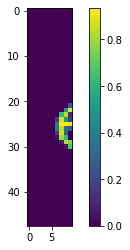

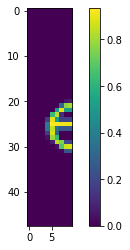

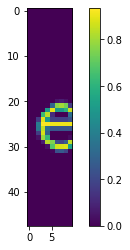

In [242]:
torch.manual_seed(123)

batch_size = 512

train_loader = DataLoader(comp_train_set, batch_size = batch_size, shuffle = True, drop_last= True)
val_loader = DataLoader(comp_val_set, batch_size = batch_size, shuffle = False, drop_last= True)
test_loader = DataLoader(comp_test_set, batch_size = batch_size, shuffle = False, drop_last= True)
test_2_loader = DataLoader(comp_test_set_2, batch_size = batch_size, shuffle = False, drop_last= True)

for image, label in train_loader:
    break
    
image_cnn = image.view(-1, color_channels, patch_height, patch_width)   
print(image.shape)
print(image_cnn.shape)
print(label)

for n_patch in range(0,3):
    patch = image[3,n_patch,0,:,:].cpu()
    plt.imshow(patch)
    plt.colorbar()
    plt.show()

In [243]:
def get_one_hot_target(labels, seq_len, output_size,batch_size):    
    one_hot_target = torch.empty(batch_size, seq_len, output_size) 

    for j,word in enumerate(labels):
        length = len(word)
        one_hot_target[j, 0, :] = mapeo['START']

        for k,letter in enumerate(word):
            one_hot_target[j, k + 1, :] = mapeo[letter]

        one_hot_target[j, length + 1, :] = mapeo['END']
        one_hot_target[j, length + 2: seq_len, :] = mapeo['PAD']
        
    return one_hot_target        

In [244]:
def one_hot_conversion(decoder_output, output_size):
    
    one_hot_output_letter = torch.zeros(1, 1, output_size).cuda(0)
    index = torch.argmax(decoder_output, dim = 2).item()
    one_hot_output_letter[0, 0, index] = 1.
    
    return one_hot_output_letter

# Definiendo la arquitectura

In [245]:
FILTROS_EN_CNN_1 = 4
NEURONS_IN_DENSE_LAYER = 1024
PATCH_HEIGHT_AFTER_POOLING = patch_height//2
PATCH_WIDTH_AFTER_POOLING = patch_width//2
kernel_size = 3

class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=FILTROS_EN_CNN_1, kernel_size=kernel_size, stride=1, padding=1, device=device)
        self.fc1 = nn.Linear(PATCH_HEIGHT_AFTER_POOLING*PATCH_WIDTH_AFTER_POOLING*FILTROS_EN_CNN_1, NEURONS_IN_DENSE_LAYER)
        
    def forward(self, X):
        X = F.relu((self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, PATCH_HEIGHT_AFTER_POOLING*PATCH_WIDTH_AFTER_POOLING*FILTROS_EN_CNN_1)
        X = self.fc1(X)

        return X

In [246]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):        
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)

    def forward(self, input, hidden, batch_size, seq_len):        
        output = input.view(batch_size, seq_len, self.input_size)
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                torch.zeros(1, batch_size, self.hidden_size, device=device))

In [247]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.lstm = nn.LSTM(output_size, hidden_size, batch_first = True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 2)
        # dim = 2 porque esta última dimensión es la correspondiente a output_size, que es sobre
        # la que queremos hacer el softmax

    def forward(self, input, hidden, batch_size, seq_len):        
        output = input.view(batch_size, seq_len, self.output_size)
        #output = F.relu(output) # la relu se metía aquí porque en el
        #caso NLP del ejemplo de PyTorch previamente había una capa de embedding
        #No nos hace falta porque nuestro tensor de inputs ya es one-hot
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size, device=device),
               torch.zeros(1, batch_size, self.hidden_size, device=device))

In [248]:
torch.manual_seed(1234)

encoder_input_size = 1024
hidden_size = 256
output_size = len(letters)

CNN_model = ConvolutionalNetwork().cuda(0)
CNN_optimizer = torch.optim.Adam(CNN_model.parameters())

Encoder_model = EncoderRNN(input_size = encoder_input_size, hidden_size = hidden_size).cuda(0)
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr = 0.001)

Decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = output_size).cuda(0)
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr = 0.001)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

## Entrenando

In [249]:
import time

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [250]:
epochs = 5000
patience = 100
min_loss_val = 10 # huge initial value for the minimum validation loss

train_losses = []
val_losses = []

torch.manual_seed(1234)

In [251]:
def calculate_loss(decoder_output, ground_truth):
    loss = 0
        
    for j in range(batch_size):
        loss += criterion(decoder_output[j], ground_truth[j])               
    
    loss = loss/batch_size

    return loss

In [252]:
def train():
    train_losses = []
    for num_batch, (image, labels) in enumerate(train_loader):        
        num_batch += 1
        encoder_hidden = Encoder_model.initHidden(batch_size)

        image_cnn = image.view(-1, color_channels, patch_height, patch_width).cuda(0)
        encoder_input = CNN_model(image_cnn)
        encoder_output, encoder_hidden = Encoder_model(encoder_input, encoder_hidden, batch_size = batch_size, seq_len = n_patches)

        decoder_hidden = encoder_hidden
        decoder_input = get_one_hot_target(labels=labels, batch_size = batch_size, seq_len = MAX_LENGTH + 2,output_size = output_size).cuda(0)
        decoder_output, decoder_hidden = Decoder_model(decoder_input, decoder_hidden, batch_size = batch_size, seq_len = MAX_LENGTH + 2)

        output_indices = torch.tensor(list(range(0, MAX_LENGTH + 2 -1))).cuda(0) # removing last token from the output
        decoder_output = torch.index_select(decoder_output, dim = 1, index = output_indices)

        ground_truth = torch.argmax(decoder_input, dim = 2)
        target_indices = torch.tensor(list(range(1, MAX_LENGTH + 2))).cuda(0) # remove SOS token from the input
        ground_truth = torch.index_select(ground_truth, dim = 1, index = target_indices)

        loss = calculate_loss(decoder_output,ground_truth)

        CNN_optimizer.zero_grad()
        Encoder_optimizer.zero_grad()
        Decoder_optimizer.zero_grad()
        loss.backward()
        CNN_optimizer.step()
        Encoder_optimizer.step()
        Decoder_optimizer.step()
        train_losses.append(loss.item())
    return np.mean(train_losses)

In [253]:
def validation():
    valid_losses = []

    with torch.no_grad():       
        for num_batch, (image_val, label_val) in enumerate(val_loader):        
            num_batch += 1
            encoder_hidden_val = Encoder_model.initHidden(batch_size = batch_size)
            image_cnn_val = image_val.view(-1, color_channels, patch_height, patch_width).cuda(0)
            encoder_input_val = CNN_model(image_cnn_val)
            encoder_output_val, encoder_hidden_val = Encoder_model(encoder_input_val, encoder_hidden_val, batch_size = batch_size, seq_len = n_patches)

            decoder_hidden_val = encoder_hidden_val
            decoder_input_val = get_one_hot_target(labels=label_val, batch_size = batch_size, seq_len = MAX_LENGTH + 2,output_size = output_size).cuda(0)
            decoder_output_val, decoder_hidden_val = Decoder_model(decoder_input_val, decoder_hidden_val,batch_size = batch_size, seq_len = MAX_LENGTH + 2)

            output_indices_val = torch.tensor(list(range(0, MAX_LENGTH + 1))).cuda(0) # remove last token from the output
            decoder_output_val = torch.index_select(decoder_output_val, dim = 1, index = output_indices_val)

            ground_truth_val = torch.argmax(decoder_input_val, dim = 2)
            target_indices_val = torch.tensor(list(range(1, MAX_LENGTH + 2))).cuda(0) # remove START token from the input
            ground_truth_val = torch.index_select(ground_truth_val, dim = 1, index = target_indices_val)
            
            loss = calculate_loss(decoder_output_val,ground_truth_val)
            valid_losses.append(loss.item())
    return np.mean(valid_losses)

In [254]:
class Patience():
    
    def __init__(self, patience):
        self.patience = patience
        self.current_patience = patience
        self.min_loss_val = float('inf')

    def more_patience(self,loss_val):
        self.current_patience -= 1
        if self.current_patience == 0:
            return False

        if loss_val < self.min_loss_val:
            self.min_loss_val = loss_val
            self.current_patience = patience

            model_name = f"{height}x{width}_by{patch_width}_jump{stepsize}_batch{batch_size} NN_{FILTROS_EN_CNN_1}_{NEURONS_IN_DENSE_LAYER}_{kernel_size}_{hidden_size} pats:{total_length}"
            print(", saved best model.")
            
            torch.save(CNN_model.state_dict(), 'CNN_'+model_name)
            torch.save(Encoder_model.state_dict(), 'Encoder_'+model_name)
            torch.save(Decoder_model.state_dict(), 'Decoder_'+model_name)
    
        return True

In [1]:
patience_controler = Patience(patience)
start_time = time.time()

for num_epoch in range(epochs):
    train_loss = train()        
    valid_loss = validation()
    
    writer.add_scalar('Loss/train', train_loss, num_epoch)
    writer.add_scalar('Loss/validation', valid_loss, num_epoch)
    
    print(f'Epoch: {num_epoch} Train loss: {train_loss} Valid loss: {valid_loss} Duration: {(time.time() - start_time)/60} minutes',)

    if not patience_controler.more_patience(valid_loss):
        print("Se acabó la paciencia")
        break

        


NameError: name 'Patience' is not defined

## Cargar modelo

In [ ]:
CNN_model.load_state_dict(torch.load('CNN_model_30000_words_TF_PAD_noise.pt'))
CNN_model.eval()

Encoder_model.load_state_dict(torch.load('Encoder_model_30000_words_TF_PAD_noise.pt'))
Encoder_model.eval()

Decoder_model.load_state_dict(torch.load('Decoder_model_30000_words_TF_PAD_noise.pt'))
Decoder_model.eval()

In [3]:
def Test():
    with torch.no_grad():
        for num_batch, (image_test, label_test) in enumerate(test_loader):
            num_batch += 1
            encoder_hidden_test = Encoder_model.initHidden(batch_size = batch_size)
            image_cnn_test = image_test.view(-1, color_channels, patch_height, patch_width).cuda(0)
            encoder_input_test = CNN_model(image_cnn_test)
            encoder_output, encoder_hidden_test = Encoder_model(encoder_input_test, encoder_hidden_test, batch = test_batch, seq_len = n_patches)

            #decoder_hidden_test = (encoder_hidden_test[0][0, :, :].view(1, batch_size, hidden_size), # We take the last hidden state of the Encoder 
            #                       encoder_hidden_test[1][0, :, :].view(1, batch_size, hidden_size)) # for each image/word (j) within the batch 
            
            for j in range(batch_size):
                decoder_input_test = mapeo['START'].cuda(0) # We initialize the first Decoder input as the START token
                decoder_hidden_test = (encoder_hidden_test[0][0, j, :].view(1, 1, hidden_size), # We take the last hidden state of the Encoder 
                                       encoder_hidden_test[1][0, j, :].view(1, 1, hidden_size)) # for each image/word (j) within the batch 
                
                for d in range(MAX_LENGTH + 2):
                    decoder_output_test, decoder_hidden_test = Decoder_model(decoder_input_test, decoder_hidden_test, batch = 1, seq_len = 1)

                    output_letter = one_hot_conversion(decoder_output_test, output_size = output_size)
                    decoder_input_test = output_letter
                    
                    if d == 0:
                        output_word = output_letter
                    else:
                        output_word = torch.cat((output_word, output_letter), dim = 1).cuda(0)
                    
                    if torch.equal(output_letter, letter_to_vector('END').cuda(0)):
                        break
                output_word = torch.argmax(output_word, dim=2)
                output_word = output_word.view(output_word.numel()) # view as a rank-1 tensor

                model_word = []
                for item in output_word:
                    model_word.append(letters[item])

                model_word = ''.join(model_word[:-1])
                print(model_word)
            print(test_set) 


In [4]:
Test()

NameError: name 'torch' is not defined